# Loading the Turkish Wkipedia Dataset

In [1]:
from google.colab import files

# Upload your kaggle credentials
files.upload()

# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mahdinamidamirchi/turkish-sentences-dataset
!unzip -q turkish-sentences-dataset
!mv wiki.tr.txt tr_wiki_sentences.txt

Saving kaggle.json to kaggle.json
  0% 0.00/3.82M [00:00<?, ?B/s]
100% 3.82M/3.82M [00:00<00:00, 136MB/s]


In [2]:
!wc -l tr_wiki_sentences.txt

170458 tr_wiki_sentences.txt


# Preprocessing

In [3]:
import re
import nltk
from nltk.tokenize import sent_tokenize

# Download the punkt tokenizer for sentence splitting
nltk.download('punkt')

def turkish_to_english(text):
  # Define Turkish and English character mappings
  turkish_chars = 'çğıöşüÇĞİÖŞÜ'
  english_equivalents = 'cgiosuCGIOSU'

  # Convert Turkish characters to English equivalents
  translation_table = str.maketrans(turkish_chars, english_equivalents)
  translated_text = text.translate(translation_table)

  return translated_text

def remove_non_alphabetical(input_string):
    # Regular expression pattern to match non-alphabetical characters
    pattern = re.compile(r'[^a-zA-Z ]')  # Matches any character that is not a letter

    # Use the pattern to substitute non-alphabetical characters with an empty string
    cleaned_string = re.sub(pattern, '', input_string)
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string.strip())

    return cleaned_string

def preprocess(text):
    text = text.strip()
    text = text.lower()
    text = turkish_to_english(text)
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
# Input and output file paths
input_file_path = 'tr_wiki_sentences.txt'
output_file_path = 'tr_wiki_sentences_prep.txt'

# Open the input and output files
with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
    # Read the Wikipedia dump file line by line
    for line in input_file:
        line = preprocess(line)
        output_file.write(line + '\n')

In [5]:
!wc -l tr_wiki_sentences.txt
!wc -l tr_wiki_sentences_prep.txt

170458 tr_wiki_sentences.txt
170458 tr_wiki_sentences_prep.txt


# Labeling

In [6]:
import re
import random
import csv

def get_indices_of_suffixes(words, suffixes):
    pairs = []

    for i, word in enumerate(words):
      for suffix in suffixes:
        if word.endswith(suffix):
          pairs.append((i, suffix))

    return pairs

def combine_suffix(words, suffix, index):
    if words[index] == suffix:
        label = 0
        words[index - 1:index + 1] = [words[index - 1] + suffix]
    else:
        label = 1
    return words, label

def label_sentences(input_file_path, output_file_path, suffixes):
  counts = [0, 0]

  suffix_dict = {}
  for suffix in suffixes:
    suffix_dict[suffix] = 0;

  with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file, delimiter=',')
    csv_writer.writerow(['Sentence', 'Label'])

    # Each line contains single sentence
    for sentence in input_file:
      words = sentence.split()

      pairs = get_indices_of_suffixes(words, suffixes)

      if pairs:
        index, suffix = pairs[0]
        words, label = combine_suffix(words, suffix, index)

        csv_writer.writerow([' '.join(words), label])

        counts[label] += 1
        suffix_dict[suffix] += 1

  return counts, suffix_dict

In [7]:
suffixes = ['de', 'ki']
input_file_path = 'tr_wiki_sentences_prep.txt'
output_file_path = 'tr_wiki_sentences_labeled.csv'

# Read from the Turkish wiki dump file
counts, suffix_counts = label_sentences(input_file_path, output_file_path, suffixes)
print(f'Number of sentences labeled as 0: {counts[0]}')
print(f'Number of sentences labeled as 1: {counts[1]}')
print(f'Total number of sentences: {sum(counts)}')

for key, value in suffix_counts.items():
  print(f'{key}: {value}')

Number of sentences labeled as 0: 6191
Number of sentences labeled as 1: 48518
Total number of sentences: 54709
de: 39048
ki: 15661


# Word Embeddings

In [8]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

## Training Word2Vec

In [ ]:
file_path = 'tr_wiki_sentences_prep.txt'

# Read sentences from the file
with open(file_path, 'r', encoding='utf-8') as file:
    sentences = [line.strip() for line in file]

# Tokenize sentences into words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

# Train Word2Vec model
embedding_dim = 100  # You can adjust the dimension based on your preference
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Save the Word2Vec model for future use
word2vec_model.save("word2vec_model_wiki_sentences.bin")

In [ ]:
# Load the pre-trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model_wiki_sentences.bin")

# Get the embedding for a specific word
embedding_for_word = word2vec_model.wv['annem']
print(f'Embedding for "annem": {embedding_for_word}')

Embedding for "annem": [ 0.00198981  0.0197558   0.02448421  0.02136626 -0.00831842 -0.06080876
  0.06945025  0.02513765 -0.02497915 -0.06514636  0.01360413 -0.03073233
  0.01459122 -0.00491728 -0.01839857  0.04252306  0.03581208  0.00213142
 -0.03799397 -0.05568204 -0.0131327   0.02047143  0.00857743 -0.01176112
  0.00253204  0.0142362  -0.00399292  0.004633    0.0098972   0.00662227
  0.00856719  0.02737785  0.02615018 -0.00426419 -0.02804015 -0.02336692
  0.05310734 -0.01930005  0.01421687 -0.01577802 -0.02008804 -0.0448346
  0.00357063 -0.01995378  0.01965951 -0.00378155 -0.01059865  0.01739278
 -0.00480235 -0.02386461  0.02404427 -0.00842587 -0.04596933 -0.02003433
 -0.00554342  0.01582928 -0.01487601 -0.01387357 -0.0065873   0.06962883
 -0.01747985  0.00921577  0.0392499   0.03564065  0.00209567  0.0685766
 -0.01127598  0.01635105 -0.0207727   0.04325216 -0.02653047  0.04385545
  0.03250389 -0.03346518 -0.00916952  0.02531049  0.0276063  -0.01834346
  0.00011127  0.01651221 -0.00

In [ ]:
word2vec_model.wv['annem'].shape

(100,)

## Loading Pre-Trained Word2Vec Model

Load the word2vec model trained on Wikipedia Turkish dump more details checkout the [GitHub repository](https://github.com/akoksal/Turkish-Word2Vec).

In [9]:
!pip install gdown
!gdown --id 1q1o2sGByIaUHd7vi5IX8KJEcJw329hgY

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1q1o2sGByIaUHd7vi5IX8KJEcJw329hgY
From (redirected): https://drive.google.com/uc?id=1q1o2sGByIaUHd7vi5IX8KJEcJw329hgY&confirm=t&uuid=96ea8560-87b1-4b19-96fb-cb0c1af4e051
To: /content/trmodel
100% 664M/664M [00:09<00:00, 70.1MB/s]


In [10]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('trmodel', binary=True)

embedding_for_word = word2vec_model['annem']
print(f'Embedding for "annem": {embedding_for_word}')

Embedding for "annem": [-2.45926276e-01 -8.93670976e-01 -6.97998479e-02  2.48153031e-01
 -8.12079832e-02  3.36787134e-01  7.05638051e-01  1.83669314e-01
  1.36171913e+00 -1.41144678e-01 -3.27689469e-01  6.15260005e-01
 -6.03327751e-01  3.79122585e-01  2.70111299e+00 -5.64137518e-01
  7.78773308e-01  7.97056675e-01  2.20021144e-01 -8.87475610e-01
 -3.48481327e-01 -6.26669049e-01 -1.07604600e-02  1.46289909e+00
 -1.77151009e-01  1.57381928e+00  3.45047861e-02 -5.53172588e-01
  1.30246490e-01  2.82778919e-01 -7.66578257e-01  5.06767690e-01
  6.27754748e-01  5.65451801e-01 -4.70315963e-01  6.54695272e-01
 -2.17029214e-01 -1.52380753e+00 -8.08578789e-01  2.18003228e-01
  8.96990180e-01  7.49978423e-02  1.90185070e-01  1.53467083e+00
 -5.07358313e-01  7.62831047e-02 -8.48436236e-01  6.78600371e-01
 -9.35373724e-01  2.36679435e-01 -9.41232204e-01 -1.23767579e+00
 -8.20650995e-01  4.70796585e-01 -2.80211300e-01 -1.05270946e+00
  5.34210980e-01  3.12256925e-02  7.44415820e-01 -6.15842223e-01
 -

In [11]:
word2vec_model['annem'].shape

(400,)

# Model Building and Training

In [12]:
import matplotlib.pyplot as plt

def plot_performance(history):
  # Accessing training/validation accuracies and losses
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(train_acc) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

embedding_dim = 400
max_length = 14  # Max number of words in turkish-sentences dataset

# Convert sentences to sequences of vectors
def sentence_to_vectors(sentence, word2vec_model, embedding_dim=100, max_length=14):
    vectors = [word2vec_model[word] for word in sentence if word in word2vec_model]
    # If a sentence is shorter than the desired length, pad with zeros
    padding = [np.zeros(embedding_dim)] * (max_length - len(vectors))
    return np.array(vectors + padding)

def sentence_to_word_embeddings(sentences, word2vec_model, embedding_dim):
  # Tokenize sentences into words
  tokenized_sentences = [word_tokenize(preprocess(sentence)) for sentence in sentences]
  # Apply the function to all sentences
  X = [sentence_to_vectors(sentence, word2vec_model, embedding_dim) for sentence in tokenized_sentences]
  X = np.array(X)
  return X

In [14]:
# File path containing sentences and labels
file_path = 'tr_wiki_sentences_labeled.csv'

# Read data from CSV file
df = pd.read_csv(file_path)

filtered_df = df[df['Sentence'].apply(lambda x: len(word_tokenize(x.lower())) <= max_length)]

# Extract sentences and labels
sentences = filtered_df['Sentence'].tolist()
labels = filtered_df['Label'].tolist()

# Convert the sentences into word embeddings
X = sentence_to_word_embeddings(sentences, word2vec_model, embedding_dim)
y = np.array(labels)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
1302/1302 [==============================] - 76s 51ms/step - loss: 0.2904 - accuracy: 0.8933 - val_loss: 0.2529 - val_accuracy: 0.9026
Epoch 2/50
1302/1302 [==============================] - 66s 50ms/step - loss: 0.2418 - accuracy: 0.9077 - val_loss: 0.2351 - val_accuracy: 0.9071
Epoch 3/50
1302/1302 [==============================] - 64s 50ms/step - loss: 0.2069 - accuracy: 0.9196 - val_loss: 0.2346 - val_accuracy: 0.9097
Epoch 4/50
1302/1302 [==============================] - 68s 52ms/step - loss: 0.1710 - accuracy: 0.9344 - val_loss: 0.2491 - val_accuracy: 0.9026
Epoch 5/50
1302/1302 [==============================] - 76s 58ms/step - loss: 0.1352 - accuracy: 0.9485 - val_loss: 0.2790 - val_accuracy: 0.9028
Epoch 6/50
1302/1302 [==============================] - 69s 53ms/step - loss: 0.1088 - accuracy: 0.9592 - val_loss: 0.3019 - val_accuracy: 0.9037


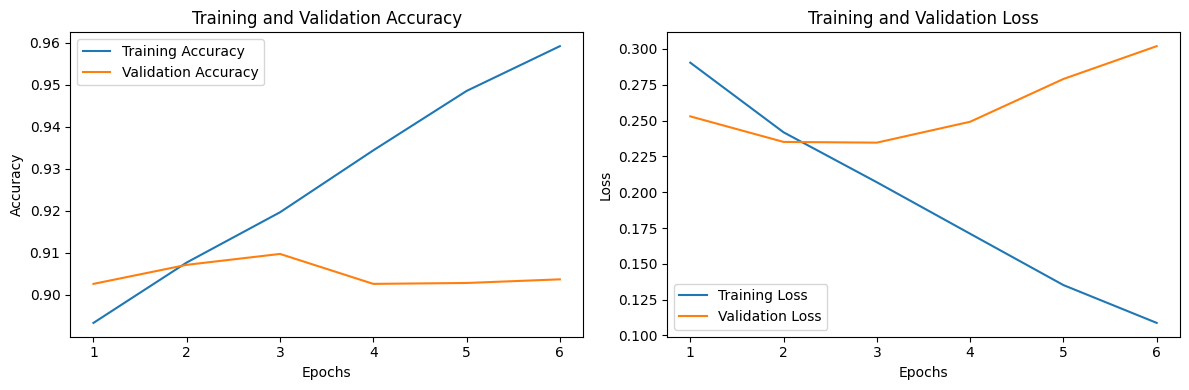

In [26]:
plot_performance(history)

In [27]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

161/161 [==============================] - 3s 21ms/step - loss: 0.2435 - accuracy: 0.9080
Test Accuracy: 90.80%


In [30]:
model.save('tr_suffix_checker.keras')

# Evaluation

In [39]:
new_sentences = [
    "Aklım hep sende kaldı.",
    "Okadar lezzetliki, yemeye kıyamıyorum.",
    "Evdeki tüm armutlar bitmiş.",
    "Cezaevinde sinema ile olan ilgisi devam etti.",
    "Kalemleri evde kalmış.",
    "Annemde bizimle gelicek.",
    "Kalemlerim annemde kaldı.",
    "Yöre halkına göre gölde bir canavar yaşamaktadır.",
    "Gunumuzde kardes kulup anlasmasi aktif degildir. ",
    "Yeni öğrencilerde geziye geldi.",
    "Yeni öğrencilerde gelişme var.",
    "Bu dönemde asyali kolelerin sayisi cok fazladir.",
    "Onlar aynı caddede buyumus ve birbirini seven iki asiktir..",
    "Evlerin tarihide eskidir.",
    "Bircok roma eyaleti bu bolgede kuruldu.",
    "Liberal koylu partiside bu partiye katildi.",
    "Gunumuzde latince olarak bilinir.",
    "Gunumuzdede latince olarak bilinir.",
    "Evini dedesinde bırakmış.",
    "Onun dedeside gelecek.",
    "Evdede yemek yokmuş.",
    "Herkes evde oturuyor.",
    "En iyiside onun doğaçlamasıydı.",
    "Onun aklı kırmızı elbisede kaldı.",
    "İlkbaharda bütün doğa canlanır.",
    "Komşunun köpeğide durmadan havlıyor.",
    "Beni yanlış anlamada o iş öyle yapılmaz.",
    "Yarın akşamda bizde ders çalışalım.",
    "Masadaki bardağı uzatır mısın?",
    "Çevremizi temiz tutalımki başkaları rahatsız olmasın.",
    "Penceremdeki çiçek soğuktan dondu.",
    "Duydumki unutmuşsun gözlerimin rengini.",
    "Beni dinlemedinki gerçekleri sana anlatayım.",
    "Kitap okuki kelime dağarcığın gelişsin.",
    "Benki hep sizin için çalıştım.",
    "Benimki yine gelmiş.",
    "Kiminki kazanacak göreceğiz.",
    "Patlıcanları ince ince doğraki güzel pişsin.",
    "Yemeklerini yeki çabuk iyileşesin.",
    "Tutki karnım acıktı, o zaman ne yapıcam?",
]

In [33]:
from keras.models import load_model

model = load_model('tr_suffix_checker.keras')

In [40]:
# Convert the sentences into word embeddings
X_new = sentence_to_word_embeddings(new_sentences, word2vec_model, embedding_dim)

# Make predictions
predictions = model.predict(X_new)

# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Display the predictions
print("Predictions:")
for i, (sentence, prediction) in enumerate(zip(new_sentences, binary_predictions), 1):
    prediction_label = "True" if prediction[0] == 1 else "False"
    print(f"{i}.) Sentence: '{sentence}'\nPrediction: {prediction_label}\n")

2/2 [==============================] - 0s 41ms/step
Predictions:
1.) Sentence: 'Aklım hep sende kaldı.'
Prediction: True

2.) Sentence: 'Okadar lezzetliki, yemeye kıyamıyorum.'
Prediction: True

3.) Sentence: 'Evdeki tüm armutlar bitmiş.'
Prediction: True

4.) Sentence: 'Cezaevinde sinema ile olan ilgisi devam etti.'
Prediction: True

5.) Sentence: 'Kalemleri evde kalmış.'
Prediction: True

6.) Sentence: 'Annemde bizimle gelicek.'
Prediction: False

7.) Sentence: 'Kalemlerim annemde kaldı.'
Prediction: True

8.) Sentence: 'Yöre halkına göre gölde bir canavar yaşamaktadır.'
Prediction: True

9.) Sentence: 'Gunumuzde kardes kulup anlasmasi aktif degildir. '
Prediction: True

10.) Sentence: 'Yeni öğrencilerde geziye geldi.'
Prediction: False

11.) Sentence: 'Yeni öğrencilerde gelişme var.'
Prediction: True

12.) Sentence: 'Bu dönemde asyali kolelerin sayisi cok fazladir.'
Prediction: True

13.) Sentence: 'Onlar aynı caddede buyumus ve birbirini seven iki asiktir..'
Prediction: True

14.) 